In [32]:
import random
from math import ceil
import copy
import heapq
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
# You’ll need display() to render in Colab/Jupyter
from IPython.display import display, HTML, Image
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

# Color maps for fire spread model

In [33]:
# Custom fire colormap: 0→white, 1→orange, 2→red
fire_cmap = ListedColormap(['#ffffff', '#fd8d3c', '#e31a1c'])
fire_norm = BoundaryNorm([0, 1, 2, 3], fire_cmap.N)

# Base classes

In [34]:
class BaseLayer(ABC):
    """Abstract base class for all CA layers."""
    def __init__(self, width: int, height: int):
        self.width, self.height = width, height
        self.grid = [[0]*width for _ in range(height)]

    @abstractmethod
    def update(self, env: 'Environment'):
        pass

In [35]:
class BaseLayer(ABC):
    """Abstract base class for all CA layers."""
    def __init__(self, width: int, height: int):
        self.width, self.height = width, height
        self.grid = [[0]*width for _ in range(height)]

    @abstractmethod
    def update(self, env: 'Environment'):
        pass

class Environment:
    """
    Holds layers and agents.
    - .set_seed(seed): fix randomness before setup
    - .save_initial_state(): snapshot for reproducible runs
    - .display(): static frame
    - .animate(steps,interval): inline animation starting at Step 0
    """
    def __init__(self, width: int, height: int):
        self.width, self.height = width, height
        self.layers = {}
        self.agents = []
        self._layers_snapshot = None
        self._agents_snapshot = None
        self._rng_snapshot = None

    def set_seed(self, seed: int):
        random.seed(seed)
        return self

    def add_layer(self, name: str, layer: BaseLayer):
        if layer.width != self.width or layer.height != self.height:
            raise ValueError("Layer size mismatch")
        self.layers[name] = layer
        return self

    def get_layer(self, name: str):
        return self.layers.get(name)

    def add_agent(self, agent: 'EvacueeAgent'):
        self.agents.append(agent)
        return self

    def spawn_agents_randomly(self, n: int, reroute_chance: float = 0.7):
        struct = self.get_layer('structure')
        if struct is None:
            raise RuntimeError("Add structure layer first")
        empties = [
            (x,y)
            for y in range(self.height)
            for x in range(self.width)
            if struct.grid[y][x] == struct.EMPTY
        ]
        if n > len(empties):
            raise ValueError(f"Only {len(empties)} free cells")
        for x,y in random.sample(empties, n):
            self.add_agent(EvacueeAgent(x,y, reroute_chance=reroute_chance))
        return self

    def get_exits(self):
        struct = self.get_layer('structure')
        exits = []
        if struct:
            for y in range(self.height):
                for x in range(self.width):
                    if struct.grid[y][x] == struct.DOOR and (
                       x in (0, self.width-1) or y in (0, self.height-1)
                    ):
                        exits.append((x,y))
        return exits

    def update_layers(self):
        for layer in self.layers.values():
            layer.update(self)

    def update_agents(self):
        for a in self.agents:
            a.update(self)

    def step(self):
        self.update_layers()
        self.update_agents()

    def _draw(self, ax):
        # 1) Fire (bottom)
        fire = self.get_layer('fire')
        if fire:
            ax.imshow(
                np.array(fire.grid),
                cmap=fire_cmap,
                norm=fire_norm,
                alpha=1.0,
                origin='lower',
                zorder=1
            )

        # 2) Smoke
        smoke = self.get_layer('smoke')
        if smoke:
            ax.imshow(
                np.array(smoke.grid),
                cmap='Blues',
                alpha=0.4,
                origin='lower',
                zorder=2
            )

        # 3) Structure: walls & doors only
        struct = self.get_layer('structure')
        if struct:
            grid = np.array(struct.grid)

            walls_mask = (grid == struct.WALL)
            ax.imshow(
                np.ma.masked_where(~walls_mask, walls_mask),
                cmap=ListedColormap(['gray']),
                alpha=1.0,
                origin='lower',
                zorder=3
            )

            doors_mask = (grid == struct.DOOR)
            ax.imshow(
                np.ma.masked_where(~doors_mask, doors_mask),
                cmap=ListedColormap(['black']),
                alpha=1.0,
                origin='lower',
                zorder=4
            )

        # 4) Light strips    
        light = self.get_layer('light')
        if light:
            for (x, y), status in light.status.items():
                color = 'cyan' if status == 'safe' else 'red'
                ax.scatter(x, y, c=color, marker='s', s=100, edgecolors='black', linewidths=0.5, zorder=4.5)

        # 5) Agents, color‐coded by health
        healthy   = [(a.x,a.y) for a in self.agents if a.alive and not a.reached and a.health > 66]
        mild      = [(a.x,a.y) for a in self.agents if a.alive and not a.reached and 33 < a.health <= 66]
        critical  = [(a.x,a.y) for a in self.agents if a.alive and not a.reached and 0 < a.health <= 33]
        dead      = [(a.x,a.y) for a in self.agents if not a.alive]

        for coords, color, marker in [
            (healthy,  'green', 'o'),
            (mild,     'yellow','o'),
            (critical, 'orange','o'),
        ]:
            if coords:
                xs, ys = zip(*coords)
                ax.scatter(xs, ys, c=color, s=20, edgecolors='black', marker=marker, zorder=5)

        if dead:
            xs, ys = zip(*dead)
            ax.scatter(xs, ys, c='red', s=20, marker='X', zorder=5)

        # 6) Legend with current counts
        #count_healthy  = len(healthy)
        #count_mild     = len(mild)
        #count_critical = len(critical)
        #count_dead     = len(dead)


        count_healthy = sum(1 for a in self.agents if a.alive and a.health>66)
        count_mild = sum(1 for a in self.agents if a.alive and 33<a.health<=66)
        count_critical = sum(1 for a in self.agents if a.alive and 0<a.health<=33)
        count_dead = sum(1 for a in self.agents if not a.alive)

        legend_handles = [
            Line2D([0],[0], marker='o', color='w',
                   label=f'Healthy: {count_healthy}',
                   markerfacecolor='green',   markeredgecolor='black', markersize=8),
            Line2D([0],[0], marker='o', color='w',
                   label=f'Mildly: {count_mild}',
                   markerfacecolor='yellow',  markeredgecolor='black', markersize=8),
            Line2D([0],[0], marker='o', color='w',
                   label=f'Critical: {count_critical}',
                   markerfacecolor='orange',  markeredgecolor='black', markersize=8),
            Line2D([0],[0], marker='X', color='w',
                   label=f'Dead: {count_dead}',
                   markerfacecolor='red',     markersize=8),
        ]
        ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.05,1))

        # 7) Title
        alive_count  = sum(1 for a in self.agents if a.alive)
        dead_count   = count_dead
        exited_count = sum(1 for a in self.agents if a.reached)
        ax.set_title(f"Alive: {alive_count}, Dead: {dead_count}, Exited: {exited_count}")
        ax.set_xticks([]); ax.set_yticks([])

    def display(self):
        fig, ax = plt.subplots(figsize=(6,6))
        fig.subplots_adjust(right=0.75)
        self._draw(ax)
        plt.show()

    def save_initial_state(self):
        """Snapshot all layers, agents, and RNG state."""
        self._layers_snapshot = copy.deepcopy(self.layers)
        self._agents_snapshot = copy.deepcopy(self.agents)
        self._rng_snapshot    = random.getstate()
        return self

    def reset(self):
        """Restore to the snapshot taken by save_initial_state()."""
        if self._layers_snapshot is None:
            raise RuntimeError("Call save_initial_state() first.")
        self.layers = copy.deepcopy(self._layers_snapshot)
        self.agents = copy.deepcopy(self._agents_snapshot)
        random.setstate(self._rng_snapshot)
        return self

    def animate(self, steps: int, interval: int=500) -> HTML:
        self.reset()
        fig, ax = plt.subplots(figsize=(8,6))
        fig.subplots_adjust(right=0.75)

        def init():
            ax.clear()
            self._draw(ax)
            ax.set_title("Step 0")
            return []

        def update(i):
            ax.clear()
            self.step()
            self._draw(ax)
            ax.set_title(f"Step {i}")
            return []

        ani = animation.FuncAnimation(
            fig, update,
            frames=range(1, steps+1),
            init_func=init,
            interval=interval,
            blit=True
        )
        #return HTML(ani.to_jshtml())
        return ani

# Concrete classes

## Class responsible for the structures

In [36]:
class StructureLayer(BaseLayer):
    EMPTY, WALL, DOOR = 0,1,2

    def add_wall(self, x1,y1,x2,y2):
        if x1==x2:
            for y in range(min(y1,y2), max(y1,y2)+1):
                self.grid[y][x1] = self.WALL
        elif y1==y2:
            for x in range(min(x1,x2), max(x1,x2)+1):
                self.grid[y1][x] = self.WALL
        else:
            raise ValueError("Only horiz/vert walls")

    def add_door(self, x,y):
        self.grid[y][x] = self.DOOR

    def create_room(self, x1,y1,x2,y2):
        self.add_wall(x1,y1,x2,y1)
        self.add_wall(x1,y2,x2,y2)
        self.add_wall(x1,y1,x1,y2)
        self.add_wall(x2,y1,x2,y2)

    def update(self, env): pass

## classes responsible for the fire-spread and smoke layers

In [37]:
class FireLayer(BaseLayer):
    UNBURNED, BURNING, BURNED = 0,1,2

    def __init__(self, w, h, *, p_ignite=0.6, burn_time=3, spread_interval=2):
        super().__init__(w, h)
        self.p_ignite        = p_ignite
        self.burn_time       = burn_time
        self.spread_interval = spread_interval
        self._timer          = [[0]*w for _ in range(h)]
        self._step_count     = 0

    def ignite(self, x: int, y: int):
        self.grid[y][x]    = self.BURNING
        self._timer[y][x]  = self.burn_time

    def update(self, env: 'Environment'):
        struct    = env.get_layer('structure')
        new_grid  = [row.copy() for row in self.grid]
        new_timer = [row.copy() for row in self._timer]
        self._step_count += 1

        for y in range(self.height):
            for x in range(self.width):
                if struct and struct.grid[y][x] == struct.WALL:
                    new_grid[y][x]   = self.UNBURNED
                    new_timer[y][x]  = 0
                    continue

                state = self.grid[y][x]
                if state == self.BURNING:
                    if self._timer[y][x] > 1:
                        new_timer[y][x] = self._timer[y][x] - 1
                        new_grid[y][x]  = self.BURNING
                    else:
                        new_timer[y][x] = 0
                        new_grid[y][x]  = self.BURNED

                elif state == self.UNBURNED and \
                     (self._step_count % self.spread_interval) == 0:
                    for dy in (-1,0,1):
                        for dx in (-1,0,1):
                            if dx==0 and dy==0: continue
                            ny, nx = y+dy, x+dx
                            if (0 <= nx < self.width and
                                0 <= ny < self.height and
                                self.grid[ny][nx] == self.BURNING and
                                random.random() <= self.p_ignite):
                                new_grid[y][x]   = self.BURNING
                                new_timer[y][x]  = self.burn_time
                                break
                        else:
                            continue
                        break

        self.grid  = new_grid
        self._timer = new_timer

In [38]:
class SmokeLayer(BaseLayer):
    def __init__(self, w, h, diff_rate=0.2, emit_rate=0.5):
        super().__init__(w, h)
        self.grid      = [[0.0]*w for _ in range(h)]
        self.diff_rate = diff_rate
        self.emit_rate = emit_rate

    def update(self, env: 'Environment'):
        fire   = env.get_layer('fire')
        struct = env.get_layer('structure')
        new    = [row.copy() for row in self.grid]

        for y in range(self.height):
            for x in range(self.width):
                if struct and struct.grid[y][x] == struct.WALL:
                    new[y][x] = 0.0
                    continue
                if fire and fire.grid[y][x] == FireLayer.BURNING:
                    new[y][x] = min(1.0, new[y][x] + self.emit_rate)
                delta = 0.0
                for dy,dx in [(-1,0),(1,0),(0,-1),(0,1)]:
                    ny, nx = y+dy, x+dx
                    if (0 <= nx < self.width and 0 <= ny < self.height and
                        not (struct and struct.grid[ny][nx] == struct.WALL)):
                        delta += (self.grid[ny][nx] - self.grid[y][x])
                new[y][x] = max(0.0, min(1.0, new[y][x] + self.diff_rate*delta))

        self.grid = new

## Evacuation Aids Classes


# Light Strips class

In [39]:
class LightStripLayer(BaseLayer):
    """
    Light strips placed near doors (which signify exits) + turn red if fire is near, stay cyan otherwise
    + Layer-based, so it stays in the same structure as the fire/smoke and main grid.
    """
    def __init__(self, width, height, door_coords, check_radius=4):
        super().__init__(width, height)
        self.door_coords = door_coords  # list of (x, y) door locations can use all doors, or only exits
        self.check_radius = check_radius
        self.status = {}  # maps (x,y) to 'safe' or 'unsafe'

        for (x, y) in door_coords:
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        self.status[(nx, ny)] = 'safe'  # Default: all safe

        # ------ CODE for only 1 light strip on exit location -------- #
        # for (x, y) in door_coords:
        #    self.status[(nx, ny)] = 'safe'  # Default: all safe

    def update(self, env):
        fire_layer = env.get_layer('fire')
        for (x, y) in self.status:
            x_min = max(0, x - self.check_radius)
            x_max = min(self.width, x + self.check_radius + 1)
            y_min = max(0, y - self.check_radius)
            y_max = min(self.height, y + self.check_radius + 1)

            fire_nearby = False
            for j in range(y_min, y_max):
                for i in range(x_min, x_max):
                    if fire_layer.grid[j][i] > 0:  # fire present
                        fire_nearby = True
                        break
                if fire_nearby:
                    break
            

            self.status[(x, y)] = 'unsafe' if fire_nearby else 'safe'
        

    def get_status(self, x, y):
        return self.status.get((x, y), 'safe')

## Evacuee Agent class

In [42]:
class EvacueeAgent:
    """
    A* pathfinder + smoke/fire avoidance + collision blocking + panic +
    gradual fire damage & health-based coloring +
    probabilistic smoke‐impairment (always one guaranteed move).
    """
    def __init__(self, x, y,
                 smoke_w=5.0, fire_w=100.0,
                 smoke_damage_rate=2.0, slow_threshold=0.5,
                 fire_damage_rate=20.0,
                 panic_radius=3, panic_smoke_threshold=0.1, panic_speed=1, 
                 reroute_chance = 0.7):
        self.x, self.y = x, y
        self.smoke_w, self.fire_w = smoke_w, fire_w
        self.smoke_damage_rate, self.slow_threshold = (
            smoke_damage_rate, slow_threshold)
        self.fire_damage_rate = fire_damage_rate
        self.panic_radius = panic_radius
        self.panic_smoke_threshold = panic_smoke_threshold
        self.panic_speed = panic_speed
        self.reroute_chance = reroute_chance

        self.health = 100.0
        self.alive = True
        self.reached = False

    def snapshot(self):
        return {
            'x': self.x, 'y': self.y,
            'health': self.health,
            'alive': self.alive,
            'reached': self.reached
        }

    @classmethod
    def from_snapshot(cls, data):
        a = cls(data['x'], data['y'])
        a.health, a.alive, a.reached = (
            data['health'], data['alive'], data['reached']
        )
        return a

    def update(self, env: 'Environment'):
        if not self.alive or self.reached:
            return

        exits = env.get_exits()
        if not exits:
            return
        
        struct = env.get_layer('structure')
        fire   = env.get_layer('fire')
        smoke  = env.get_layer('smoke')
        light = env.get_layer('light')

        # Checks for safe exits
        light_status = {}  # maps exit coords to 'safe'/'unsafe'
        if light:
            for ex, ey in exits:
                light_status[(ex, ey)] = light.get_status(ex, ey)

        # Filter exits based on light strip + distance + reroute chance
        filtered_exits = []
        for ex, ey in exits:
            dist = abs(self.x - ex) + abs(self.y - ey)
            status = light_status.get((ex, ey), 'safe')
            if status == 'safe':
                filtered_exits.append((ex, ey))
            else:
                if dist <= 3:  # Too close to change mind
                    filtered_exits.append((ex, ey))
                else:
                    # Use reroute chance
                    if random.random() < self.reroute_chance:
                        continue  # Skip this exit
                    else:
                        filtered_exits.append((ex, ey))

        # Fallback: if all were filtered out, use all exits
        if not filtered_exits:
            filtered_exits = exits

        # smoke damage
        conc = smoke.grid[self.y][self.x] if smoke else 0.0
        self.health -= conc * self.smoke_damage_rate

        # gradual fire damage
        if fire and fire.grid[self.y][self.x] == FireLayer.BURNING:
            self.health -= self.fire_damage_rate

        # check for death
        if self.health <= 0.0:
            self.alive = False
            return

        # detect panic in radius
        panic = False
        r = self.panic_radius
        for dy in range(-r, r+1):
            for dx in range(-r, r+1):
                ny, nx = self.y+dy, self.x+dx
                if 0 <= nx < env.width and 0 <= ny < env.height:
                    if ((fire and fire.grid[ny][nx] == FireLayer.BURNING) or
                        (smoke and smoke.grid[ny][nx] >= self.panic_smoke_threshold)):
                        panic = True
                        break
            if panic:
                break

        # compute number of moves with health‐based panic boost
        if panic:
            h = self.health
            if h >= 80:
                mult = 1.0
            elif h >= 40:
                mult = 2.0
            else:
                mult = max(0.1, h / 40.0)
        else:
            mult = 0.0

        moves = 1 + ceil(self.panic_speed * mult)

        # prepare occupancy and cost/heuristic functions
        occupied = {
            (a.x, a.y)
            for a in env.agents
            if a is not self and a.alive and not a.reached
        }

        def cost(cx, cy):
            if (cx, cy) in occupied:
                return float('inf')
            base = 1.0
            if fire:
                s = fire.grid[cy][cx]
                if s == FireLayer.BURNING:
                    base += self.fire_w
                elif s == FireLayer.BURNED:
                    base += self.fire_w / 2
            if smoke:
                base += smoke.grid[cy][cx] * self.smoke_w
            return base

        def heuristic(cx, cy):
            # return min(abs(cx-ex) + abs(cy-ey) for ex,ey in exits)
            return min(abs(cx-ex) + abs(cy-ey) for ex,ey in filtered_exits) # modified version

        # perform up to `moves` steps, but probabilistically impaired by smoke
        for step_i in range(moves):
            conc = smoke.grid[self.y][self.x] if smoke else 0.0
            on_fire = (fire and fire.grid[self.y][self.x] == FireLayer.BURNING)

            # guaranteed first hop
            if step_i == 0:
                can_move = True
            else:
                # chance ∝ (1 - conc)
                can_move = (random.random() < max(0.0, 1 - conc))
                # adrenaline override if on fire
                if on_fire:
                    can_move = can_move or (random.random() < 0.5)

            if not can_move:
                break

            # run one‐step A* toward nearest exit
            start = (self.x, self.y)
            open_set = [(heuristic(*start), 0.0, start, None)]
            came_from = {}
            g_score = {start: 0.0}
            visited = set()
            target = None

            while open_set:
                f, g, (cx,cy), parent = heapq.heappop(open_set)
                if (cx,cy) in visited:
                    continue
                visited.add((cx,cy))
                came_from[(cx,cy)] = parent
                if (cx,cy) in exits:
                    target = (cx,cy)
                    break
                for dx,dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                    nx, ny = cx+dx, cy+dy
                    if not (0<=nx<env.width and 0<=ny<env.height):
                        continue
                    if struct and struct.grid[ny][nx] == struct.WALL:
                        continue
                    step = cost(nx,ny)
                    if step == float('inf'):
                        continue
                    tg = g + step
                    if tg < g_score.get((nx,ny), float('inf')):
                        g_score[(nx,ny)] = tg
                        heapq.heappush(open_set,
                            (tg + heuristic(nx,ny), tg, (nx,ny), (cx,cy)))

            if not target:
                return  # no path

            # reconstruct one‐cell move
            node = target
            path = []
            while node != start:
                path.append(node)
                node = came_from.get(node)
                if node is None:
                    return
            nx, ny = path[-1]
            self.x, self.y = nx, ny

            if (nx,ny) in exits:
                self.reached = True
                break

# Demo 1 - Big Structure two rooms, door, 2 exits

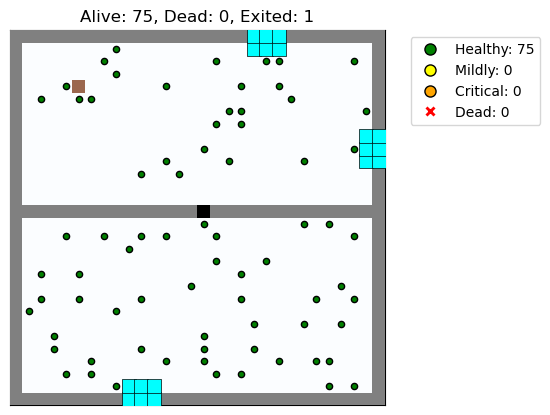

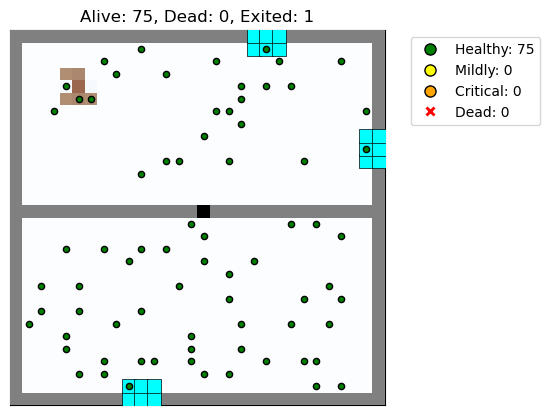

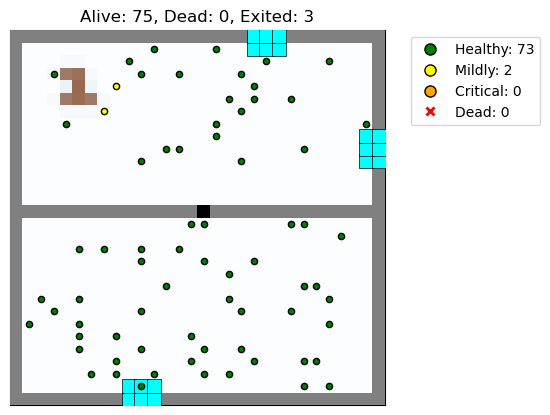

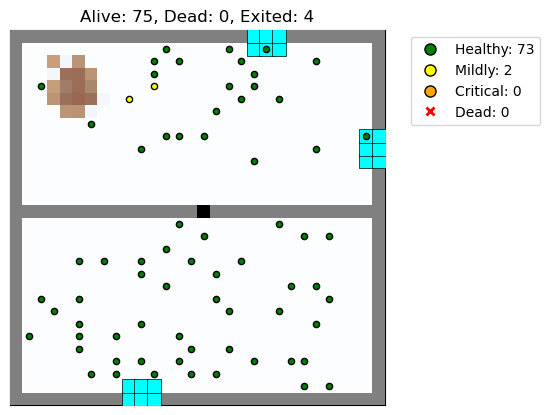

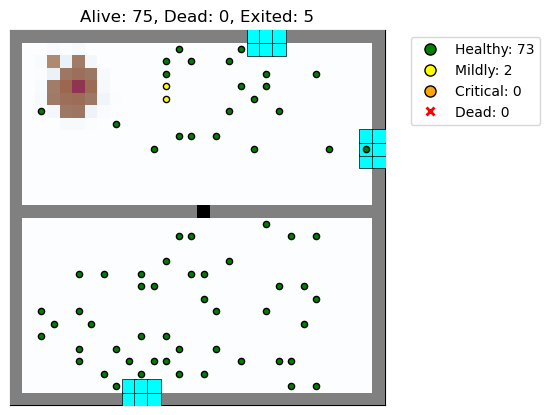

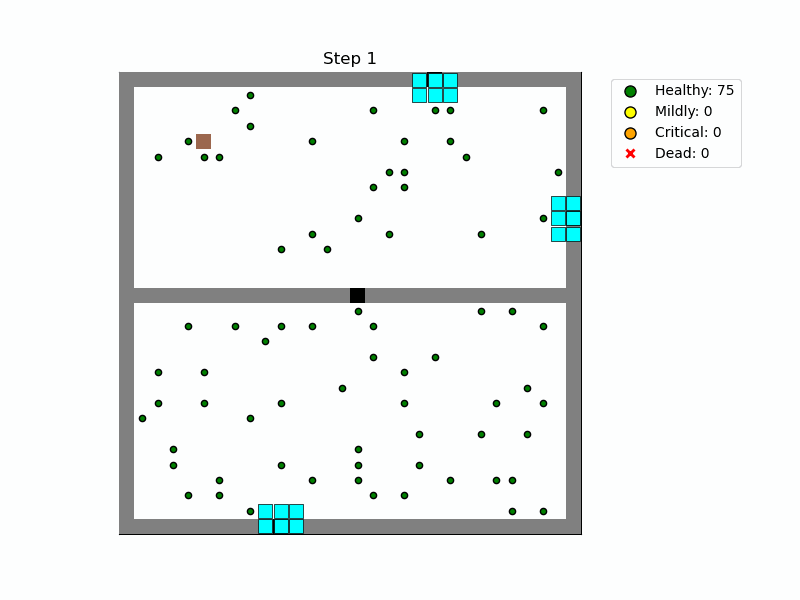

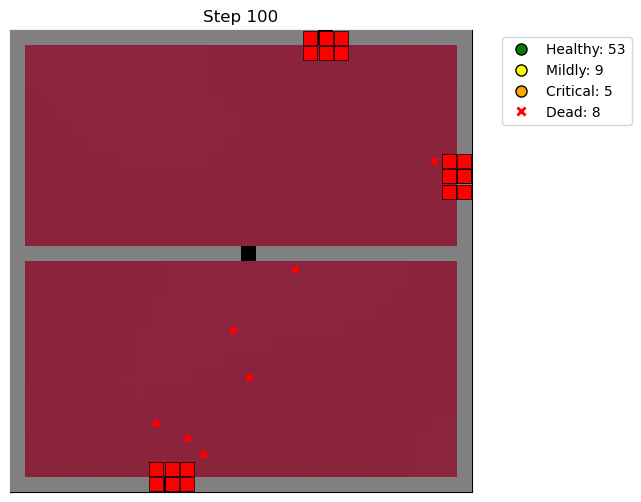

In [ ]:
if __name__ == "__main__":
    # build & seed
    env = Environment(30,30).set_seed(42)

    # layers & ignition
    struct = StructureLayer(30,30)
    struct.create_room(0,0,29,29)
    struct.add_wall(0,15,29,15)
    struct.add_door(15,15)
    struct.add_door(10,0)
    struct.add_door(29,20)
    struct.add_door(20,29)
    env.add_layer('structure', struct)

    fire = FireLayer(30,30, p_ignite=0.5, burn_time=5, spread_interval=2)
    env.add_layer('fire', fire)
    fire.ignite(5,25)

    smoke = SmokeLayer(30,30, diff_rate=0.1, emit_rate=0.4)
    env.add_layer('smoke', smoke)

    exits = env.get_exits()
    light = LightStripLayer(30, 30, exits)
    env.add_layer('light', light)

    env.spawn_agents_randomly(75, reroute_chance=0.7)
    env.save_initial_state()

    # static preview
    for i in range(5):
        env.step()
        env.display()

    # animation
    anim = env.animate(steps=100, interval=200)
    anim.save('evac-1.gif', writer='pillow', fps=5)
    #display(anim)
    display(Image(filename='evac-1.gif'))
    #display(HTML(anim.to_jshtml()))

# Demo 2 - small structure, two rooms, 1 exit (Herding Behavior)

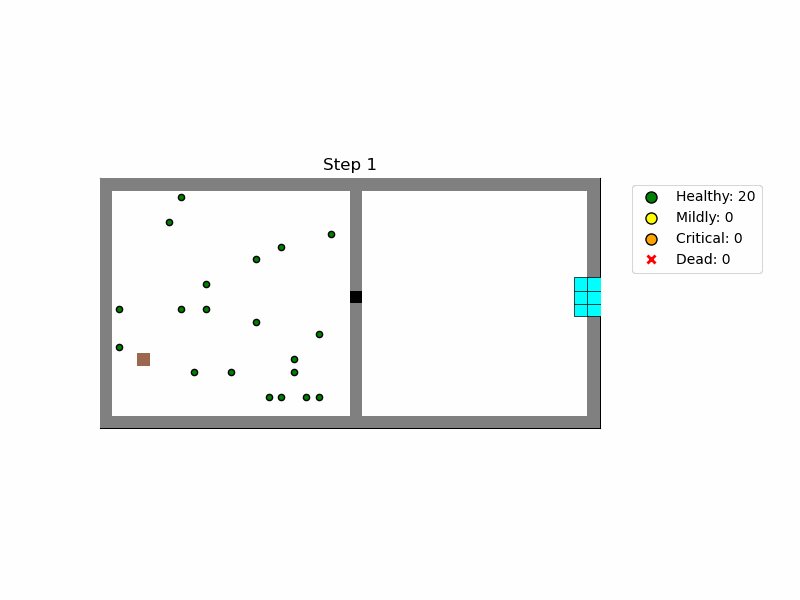

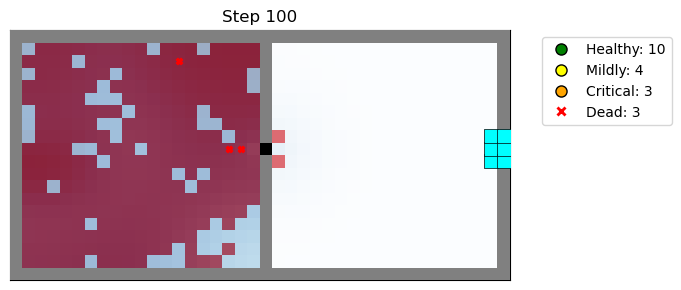

In [24]:
if __name__ == "__main__":
    # You’ll need display() to render in Colab/Jupyter
    from IPython.display import display, HTML

    # Build a mid-size environment and fix the RNG
    W, H = 40, 20
    env = Environment(W, H).set_seed(42)

    # Create outer walls
    struct = StructureLayer(W, H)
    struct.create_room(0, 0, W-1, H-1)

    # Add a full-height interior wall at x = W//2, leaving a 1-cell bottleneck
    mid_x = W // 2
    struct.add_wall(mid_x, 0, mid_x, H-1)
    # carve out the single-cell “doorway” in that wall
    door_y = H // 2
    struct.add_door(mid_x, door_y)

    # Place the real exit on the right boundary at the same y
    struct.add_door(W-1, door_y)

    env.add_layer('structure', struct)

    fire = FireLayer(40,20, p_ignite=0.3, burn_time=2, spread_interval=2)
    env.add_layer('fire', fire)
    fire.ignite(3,5)

    smoke = SmokeLayer(40,20, diff_rate=0.1, emit_rate=0.4)
    env.add_layer('smoke', smoke)

    exits = env.get_exits()
    light = LightStripLayer(40, 20, exits)
    env.add_layer('light', light)

    # To simulate congestion
    # (the agents will default to shortest‐path & blocking behavior)
    # Spawn 50 agents randomly in the *left* chamber only:
    left_cells = [
        (x, y)
        for y in range(1, H-1)
        for x in range(1, mid_x)
        if struct.grid[y][x] == struct.EMPTY
    ]

    # Spawn random agents in the left-room
    for x, y in random.sample(left_cells, 20):
        env.add_agent(EvacueeAgent(x, y))

    # Snapshot this as “step 0”
    env.save_initial_state()

    # Fire off a long animation so you can watch the bottleneck jam up
    #anim = env.animate(steps=200, interval=100)

    #display(anim)
    #display(HTML(anim.to_jshtml()))

    anim = env.animate(steps=100, interval=100)
    # 1000ms/100ms = 10 fps
    anim.save('evac-2.gif', writer='pillow', fps=5)

    # 2) display the GIF file we just wrote
    display(Image(filename='evac-2.gif'))
